# InfluxDB Benchmarks – Big Experiments

## Libraries

In [1]:
from fabric import ThreadingGroup, Connection
from chi import server, ssh
import os
import warnings
import time
import sys
sys.path.append('../scripts')
from utilities import *
warnings.filterwarnings('ignore')

## Configurations

In [2]:
sshUser = "ubuntu"
server_ips = ["64.131.114.152"]
server_local_ips = {}
client_ips = ["64.131.114.143", "64.131.114.144", "64.131.114.145", "64.131.114.146",
              "64.131.114.147", "64.131.114.148", "64.131.114.153", "64.131.114.154"]

storageType = {"HDD": "/HDD", "NVME": "/NVME_RAID-0"}
SERVER_WORKING_DIR = storageType["NVME"]

## Initialize environment

In [3]:
# These groups are for processing in parallel 
serverConnections = [Connection(i, user=sshUser) for i in server_ips]
clientConnections = [Connection(i, user=sshUser) for i in client_ips]
allConnections = (serverConnections + clientConnections)
serverGroup = ThreadingGroup.from_connections(serverConnections)
clientGroup = ThreadingGroup.from_connections(clientConnections)
allGroup = ThreadingGroup.from_connections(allConnections)

# Get local IP for server
local_ips = serverGroup.run("hostname -I | cut -d ' ' -f 1", hide=True)
for i in local_ips:
    server_local_ips[i.host] = local_ips[i].stdout.strip()

In [4]:
# Update & Upgrade latest packages
allGroup.run(f"sudo apt update; sudo apt upgrade -y; sudo shutdown -r +1", hide=True)
allGroup.close()

Wait for all server to come online after reboot

In [5]:
# Buffer of reboot
time.sleep(70)

for ip in (server_ips + client_ips):
    server.wait_for_tcp(ip, 22, timeout=1200)

## Datasets

Preparing test datasets on client nodes

In [6]:
clientGroup.put("../scripts/initData.sh")
clientGroup.run("bash initData.sh", hide=True)
clientGroup.close()

## Benchmark server (InfluxDB)

Prepare benchmark server

In [7]:
serverGroup.put("../scripts/InfluxDB/initInfluxDBServer.sh")
serverGroup.run(f"sudo chmod -R 777 {SERVER_WORKING_DIR}; bash initInfluxDBServer.sh {SERVER_WORKING_DIR} true", hide=True)
serverGroup.close()

## Benchmark client (XBench)
Prepare benchmark client

In [8]:
clientGroup.put("../scripts/initXBenchClient.sh")
clientGroup.run("bash initXBenchClient.sh", hide=True)
clientGroup.close()

## Experiments - Settings

In [9]:
targetThreads = [1, 2, 4, 8]
numClients = [i * len(client_ips) for i in targetThreads]

## Experiment – UNARY INSERT (SEQ)
**Perform experiments**

In [10]:
runWorkload("INSERT_UNARY_SEQ", targetThreads, server_local_ips[server_ips[0]], 9492, "InfluxDB", client_ips, 1000, 0, serverGroup, SERVER_WORKING_DIR, "ubuntu")

[Benchmark: 1] - Schedule workload on 1732669922
[Benchmark: 1] [Client: 64.131.114.143] - Time now: 1732669869 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.143] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1732670101
[Benchmark: 2] [Client: 64.131.114.143] - Time now: 1732670047 | Delta: 54
[Benchmark: 2] [Client: 64.131.114.143] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1732670286
[Benchmark: 4] [Client: 64.131.114.143] - Time now: 1732670232 | Delta: 54
[Benchmark: 4] [Client: 64.131.114.143] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1732670543
[Benchmark: 8] [Client: 64.131.114.143] - Time now: 1732670430 | Delta: 113
[Benchmark: 8] [Client: 64.131.114.144] - Time now: 1732670437 | Delta: 106
[Benchmark: 8] [Client: 64.131.114.145] - Time now: 173

**Visualization**

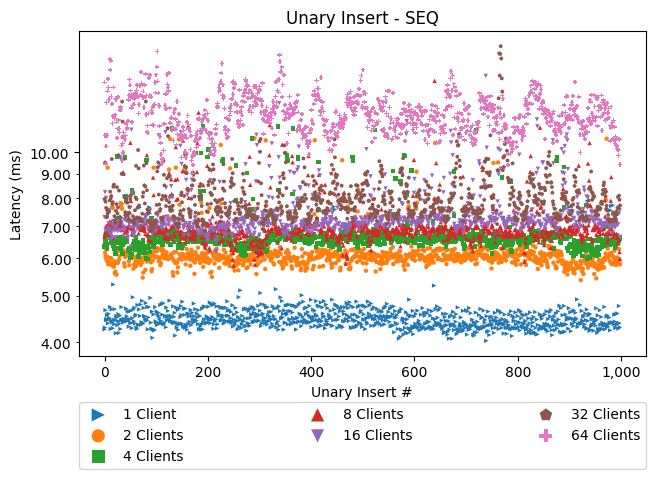

In [11]:
unaryPlots("INSERT_UNARY_SEQ", "InfluxDB", targetThreads, client_ips, logScale=True)

## Experiment – UNARY INSERT (RAND)
**Perform experiments**

In [12]:
runWorkload("INSERT_UNARY_RAND", targetThreads, server_local_ips[server_ips[0]], 9492, "InfluxDB", client_ips, 1000, 0, serverGroup, SERVER_WORKING_DIR, "ubuntu")

[Benchmark: 1] - Schedule workload on 1732671976
[Benchmark: 1] [Client: 64.131.114.143] - Time now: 1732671923 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.143] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1732672155
[Benchmark: 2] [Client: 64.131.114.143] - Time now: 1732672101 | Delta: 54
[Benchmark: 2] [Client: 64.131.114.143] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1732672341
[Benchmark: 4] [Client: 64.131.114.143] - Time now: 1732672287 | Delta: 54
[Benchmark: 4] [Client: 64.131.114.143] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1732672598
[Benchmark: 8] [Client: 64.131.114.143] - Time now: 1732672484 | Delta: 114
[Benchmark: 8] [Client: 64.131.114.144] - Time now: 1732672491 | Delta: 107
[Benchmark: 8] [Client: 64.131.114.145] - Time now: 173

**Visualization**

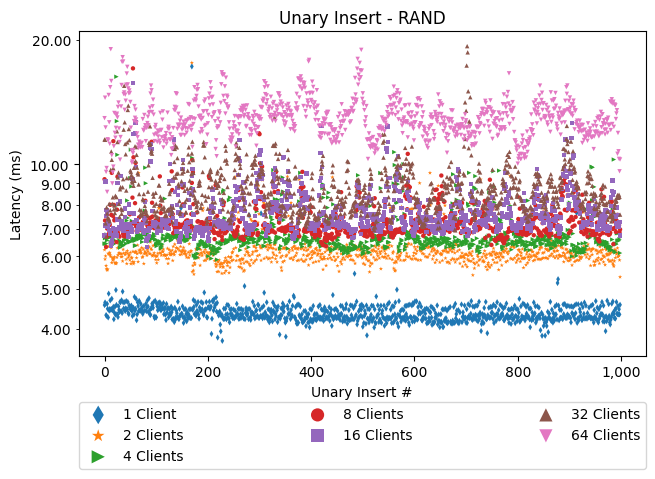

In [13]:
unaryPlots("INSERT_UNARY_RAND", "InfluxDB", targetThreads, client_ips, logScale=True)

## Experiment – BATCH INSERT (SEQ)
**Perform experiments**

In [14]:
runWorkload("INSERT_BATCH_SEQ", targetThreads, server_local_ips[server_ips[0]], 9492, "InfluxDB", client_ips, 1000, 10, serverGroup, SERVER_WORKING_DIR, "ubuntu")

[Benchmark: 1] - Schedule workload on 1732674036
[Benchmark: 1] [Client: 64.131.114.143] - Time now: 1732673983 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.143] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1732674217
[Benchmark: 2] [Client: 64.131.114.143] - Time now: 1732674164 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.143] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1732674404
[Benchmark: 4] [Client: 64.131.114.143] - Time now: 1732674350 | Delta: 54
[Benchmark: 4] [Client: 64.131.114.143] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1732674663
[Benchmark: 8] [Client: 64.131.114.143] - Time now: 1732674550 | Delta: 113
[Benchmark: 8] [Client: 64.131.114.144] - Time now: 1732674556 | Delta: 107
[Benchmark: 8] [Client: 64.131.114.145] - Time now: 173

**Visualization**

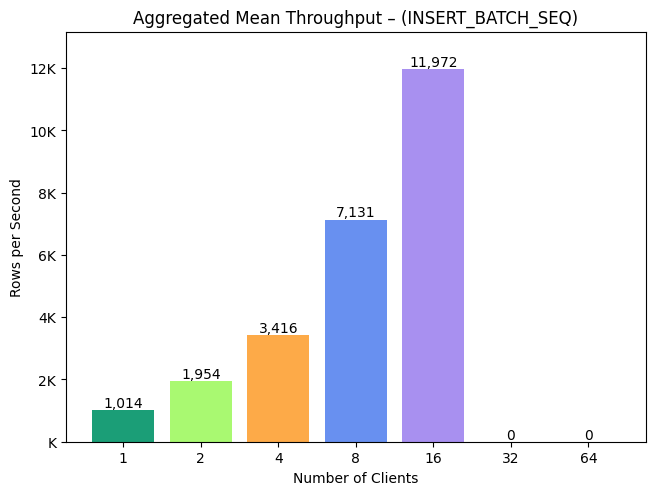

In [15]:
batchPlots("INSERT_BATCH_SEQ", "InfluxDB", targetThreads, client_ips)

## Experiment – BATCH INSERT (SEQ)
**Perform experiments**

In [16]:
runWorkload("INSERT_BATCH_RAND", targetThreads, server_local_ips[server_ips[0]], 9492, "InfluxDB", client_ips, 1000, 10, serverGroup, SERVER_WORKING_DIR, "ubuntu")

[Benchmark: 1] - Schedule workload on 1732676103
[Benchmark: 1] [Client: 64.131.114.143] - Time now: 1732676050 | Delta: 53
[Benchmark: 1] [Client: 64.131.114.143] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1732676284
[Benchmark: 2] [Client: 64.131.114.143] - Time now: 1732676230 | Delta: 54
[Benchmark: 2] [Client: 64.131.114.143] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1732676470
[Benchmark: 4] [Client: 64.131.114.143] - Time now: 1732676417 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.143] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1732676728
[Benchmark: 8] [Client: 64.131.114.143] - Time now: 1732676615 | Delta: 113
[Benchmark: 8] [Client: 64.131.114.144] - Time now: 1732676622 | Delta: 106
[Benchmark: 8] [Client: 64.131.114.145] - Time now: 173

**Visualization**

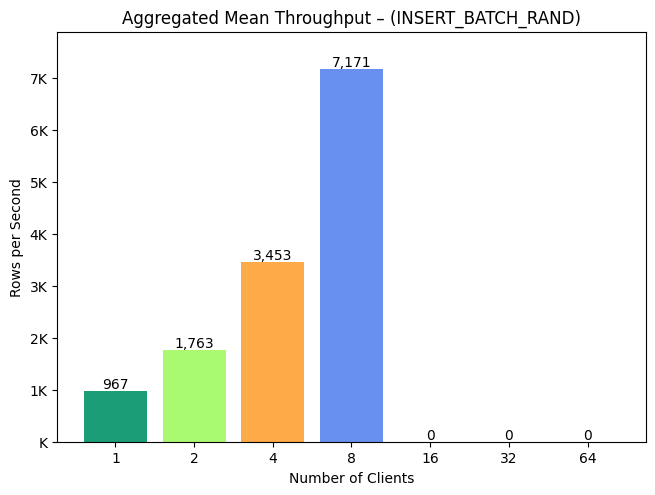

In [17]:
batchPlots("INSERT_BATCH_RAND", "InfluxDB", targetThreads, client_ips)

## Bootstrap Database

Reboot server to a fresh state to avoid becoming non-accessible from public network

In [18]:
allGroup.run(f"sudo shutdown -r +1", hide=True)
allGroup.close()

# Buffer of reboot
time.sleep(70)

for ip in (server_ips + client_ips):
    server.wait_for_tcp(ip, 22, timeout=1200)

<div class="alert alert-block alert-info">Note: This is required so that there's actual data for clients to query from</div>

In [19]:
serverGroup.put("../scripts/restoreDB.sh")
serverGroup.close()

# Restore DB
serverGroup.run(f"bash restoreDB.sh CHI@UC InfluxDB {SERVER_WORKING_DIR}", hide=True)
serverGroup.close()

# Keep checking if job is done running in tmux window
checkTmuxJobIsDone(serverGroup)

## Experiment – UNARY QUERY (SEQ)

**Perform experiments**

In [20]:
runWorkload("QUERY_UNARY_SEQ", targetThreads, server_local_ips[server_ips[0]], 9492, "InfluxDB", client_ips, 1000, 0, serverGroup, SERVER_WORKING_DIR, "ubuntu")

[Benchmark: 1] - Schedule workload on 1732683942
[Benchmark: 1] [Client: 64.131.114.143] - Time now: 1732683888 | Delta: 54
[Benchmark: 1] [Client: 64.131.114.143] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1732684130
[Benchmark: 2] [Client: 64.131.114.143] - Time now: 1732684077 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.143] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1732684320
[Benchmark: 4] [Client: 64.131.114.143] - Time now: 1732684266 | Delta: 54
[Benchmark: 4] [Client: 64.131.114.143] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1732684586
[Benchmark: 8] [Client: 64.131.114.143] - Time now: 1732684473 | Delta: 113
[Benchmark: 8] [Client: 64.131.114.144] - Time now: 1732684479 | Delta: 107
[Benchmark: 8] [Client: 64.131.114.145] - Time now: 173

**Visualization**

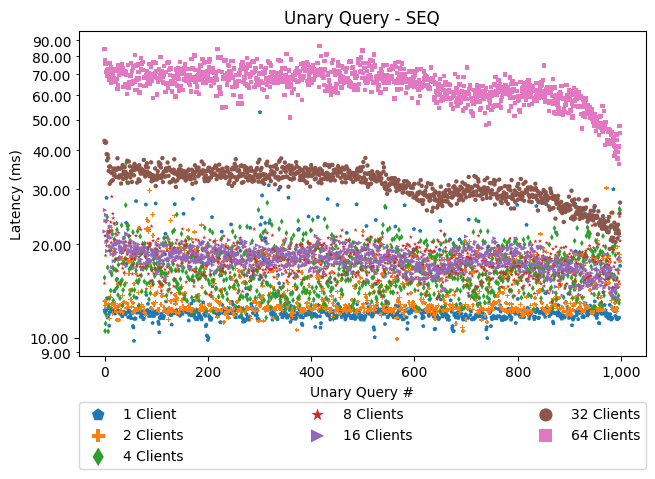

In [21]:
unaryPlots("QUERY_UNARY_SEQ", "InfluxDB", targetThreads, client_ips, logScale=True)

## Experiment – UNARY QUERY (RAND)

**Perform experiments**

In [22]:
runWorkload("QUERY_UNARY_RAND", targetThreads, server_local_ips[server_ips[0]], 9492, "InfluxDB", client_ips, 1000, 0, serverGroup, SERVER_WORKING_DIR, "ubuntu")

[Benchmark: 1] - Schedule workload on 1732686043
[Benchmark: 1] [Client: 64.131.114.143] - Time now: 1732685989 | Delta: 54
[Benchmark: 1] [Client: 64.131.114.143] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1732686282
[Benchmark: 2] [Client: 64.131.114.143] - Time now: 1732686228 | Delta: 54
[Benchmark: 2] [Client: 64.131.114.143] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1732686526
[Benchmark: 4] [Client: 64.131.114.143] - Time now: 1732686472 | Delta: 54
[Benchmark: 4] [Client: 64.131.114.143] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1732686849
[Benchmark: 8] [Client: 64.131.114.143] - Time now: 1732686736 | Delta: 113
[Benchmark: 8] [Client: 64.131.114.144] - Time now: 1732686742 | Delta: 107
[Benchmark: 8] [Client: 64.131.114.145] - Time now: 173

**Visualization**

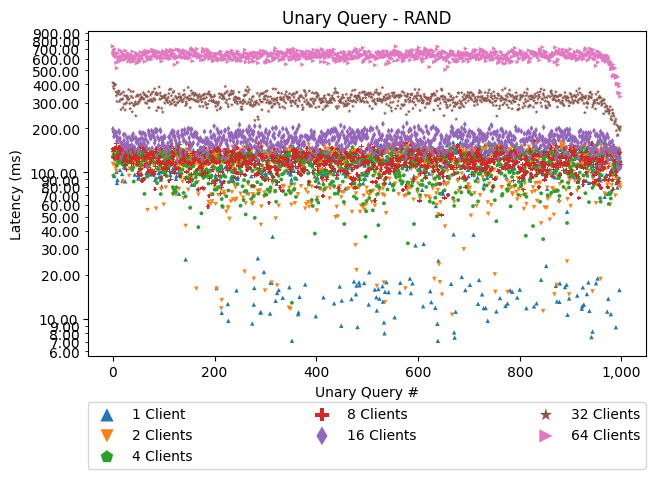

In [23]:
unaryPlots("QUERY_UNARY_RAND", "InfluxDB", targetThreads, client_ips, logScale=True)

## Experiment – BATCH QUERY (SEQ)

**Perform experiments**

In [24]:
runWorkload("QUERY_BATCH_SEQ", targetThreads, server_local_ips[server_ips[0]], 9492, "InfluxDB", client_ips, 100, 1000, serverGroup, SERVER_WORKING_DIR, "ubuntu")

[Benchmark: 1] - Schedule workload on 1732689379
[Benchmark: 1] [Client: 64.131.114.143] - Time now: 1732689325 | Delta: 54
[Benchmark: 1] [Client: 64.131.114.143] - Downloaded 1 result files
[Benchmark: 1] [Server] - Downloaded system stats files
[Benchmark: 2] - Schedule workload on 1732689681
[Benchmark: 2] [Client: 64.131.114.143] - Time now: 1732689628 | Delta: 53
[Benchmark: 2] [Client: 64.131.114.143] - Downloaded 2 result files
[Benchmark: 2] [Server] - Downloaded system stats files
[Benchmark: 4] - Schedule workload on 1732689995
[Benchmark: 4] [Client: 64.131.114.143] - Time now: 1732689942 | Delta: 53
[Benchmark: 4] [Client: 64.131.114.143] - Downloaded 4 result files
[Benchmark: 4] [Server] - Downloaded system stats files
[Benchmark: 8] - Schedule workload on 1732690383
[Benchmark: 8] [Client: 64.131.114.143] - Time now: 1732690269 | Delta: 114
[Benchmark: 8] [Client: 64.131.114.144] - Time now: 1732690275 | Delta: 108
[Benchmark: 8] [Client: 64.131.114.145] - Time now: 173

**Visualization**

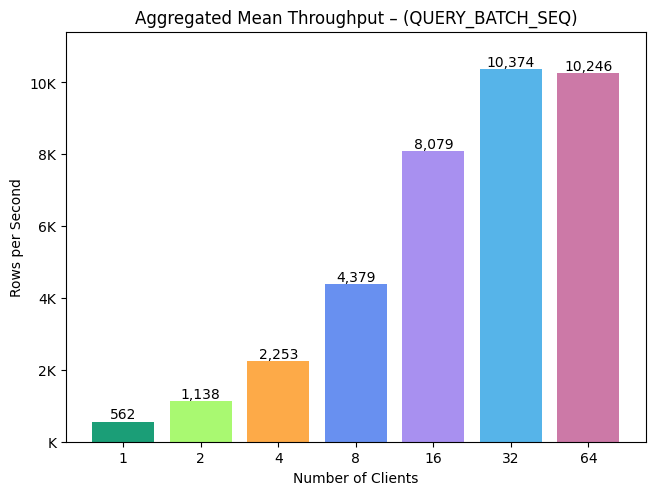

In [25]:
batchPlots("QUERY_BATCH_SEQ", "InfluxDB", targetThreads, client_ips, 100)